In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import jax
import jax.numpy as jnp
import torch.nn.functional as F
from einops import rearrange
import random

/home/aradha/anaconda3/envs/nt_pooling/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 1717
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
import matplotlib.pyplot as plt

In [5]:
import neural_tangents as nt
import neural_tangents.stax as stax

In [6]:
from tqdm import tqdm
import time
import argparse
import csv
import os
import pickle

In [7]:
import sys
sys.path.append("./crfm_src")

import models
import utils
import grads
import dataset

## Star dataset

In [8]:
n_train = 50
n_test = 1000

train_X, test_X, train_y, test_y = dataset.get_star(n_train, n_test)

num_classes = 2
reg = 1e-3
ps = 11
depth = 1
num_iters = 2

In [9]:
train_X_exp = utils.expand_image(train_X, ps)
test_X_exp = utils.expand_image(test_X, ps)

train_X_exp = torch.moveaxis(train_X_exp,1,-1).numpy()
test_X_exp = torch.moveaxis(test_X_exp,1,-1).numpy()
y_train = train_y.numpy()
y_test = test_y.numpy()
train_X_exp, test_X_exp = jnp.array(train_X_exp), jnp.array(test_X_exp)

_, _, kernel_fn = models.Vanilla(ps=ps, depth=depth, expanded=True)

In [10]:
accs = []
mses = []
M = None
for t in range(num_iters):

    if M is not None:
        del train_X_M
        del test_X_M

        train_X_M = utils.multiply_patches(train_X_exp, M, ps)
        test_X_M = utils.multiply_patches(test_X_exp, M, ps)
    else:
        train_X_M = train_X_exp
        test_X_M = test_X_exp


    start = time.time()
    Ktrain = utils.batch_kernel(kernel_fn, train_X_M, train_X_M)
    end = time.time()
    print(f'Ktrain time {end-start}')

    start = time.time()
    Ktest = utils.batch_kernel(kernel_fn, test_X_M, train_X_M)
    end = time.time()
    print(f'Ktest time {end-start}')

    scale = Ktrain.max()
    Ktrain /= scale
    Ktest /= scale

    start = time.time()
    alphas=np.linalg.solve(reg*np.eye(n_train, dtype=np.float32)+Ktrain, y_train.astype(np.float32))
    end = time.time()
    print(f'Solve time {end-start}')

    ypred = Ktest@alphas
    acc = np.mean(1.0*(np.argmax(ypred,axis=1) == np.argmax(y_test,axis=1))) * 100
    mse = np.mean(np.sum((ypred - y_test)**2,axis=1))

    accs.append(acc)
    mses.append(mse)
    print(f'Round {t} accuracy:', acc)
    print(f'Round {t} MSE:', mse)
    print()
    
    if t < num_iters - 1:
        s = 20
        Xs = train_X_exp[:s]
        M = grads.get_grads(kernel_fn, jnp.array(alphas), train_X_M, Xs, M, num_classes, ps)

        M = utils.matrix_sqrt(M)
        M = jnp.array(M.numpy())
        M = M/np.linalg.norm(M)

Ktrain time 2.668579578399658
Ktest time 2.697782516479492
Solve time 0.0005481243133544922
Round 0 accuracy: 77.95121951219512
Round 0 MSE: 0.40176222



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.68s/it]


Ktrain time 0.06955122947692871
Ktest time 1.7804875373840332
Solve time 0.00033926963806152344
Round 1 accuracy: 94.82926829268293
Round 1 MSE: 0.16489121



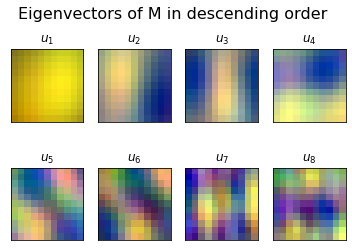

In [11]:
# plot top k eigvs of M
def scale(x):
    return (x - x.min())/(x.max() - x.min())

fig, axes = plt.subplots(2,4)
fig.suptitle("Eigenvectors of M in descending order", fontsize=16)

topk = 8 
S, U = jnp.linalg.eigh(M)
i = 0
j = 0
for k in range(topk):
    uk = U[:,-1-k]
    uk = np.transpose(uk.reshape(3,11,11),(1,2,0))
    
    if k==4:
        j += 1
        i = 0
    
    ax = axes[j][i]
    ax.imshow(scale(uk))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(rf'$u_{k+1}$')
    
    i += 1

## Visualizing transformed data samples

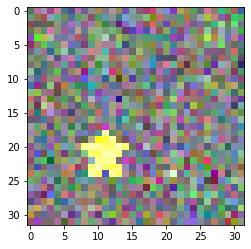

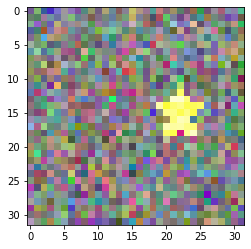

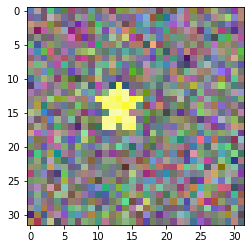

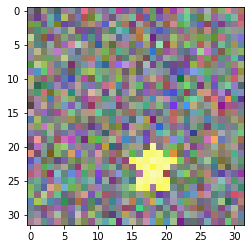

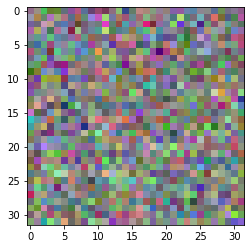

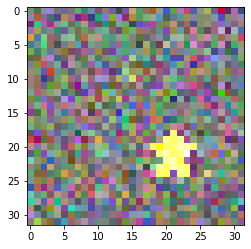

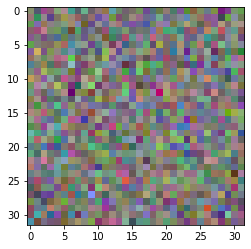

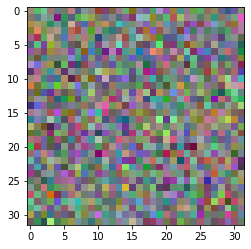

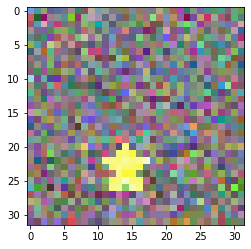

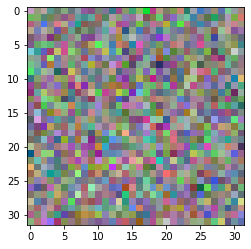

In [14]:
def img_for_viewing(X):
    n, c, p, q = X.shape
    X = rearrange(X, 'n c p q -> n p q c', n=n, c=c, p=p, q=q)[0]
    return scale(X)

# Here is what a sample looks like before transforming by the operator M
for i in range(10):
    sample_X = train_X[i].unsqueeze(0)
    plt.imshow(img_for_viewing(sample_X))
    plt.show()

torch.Size([363, 363])


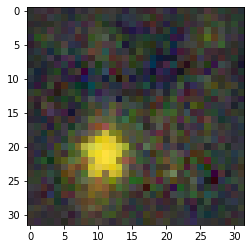

torch.Size([363, 363])


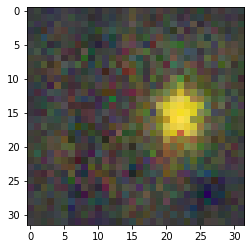

torch.Size([363, 363])


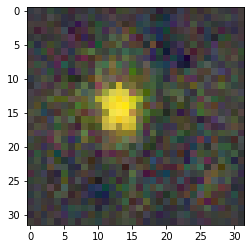

torch.Size([363, 363])


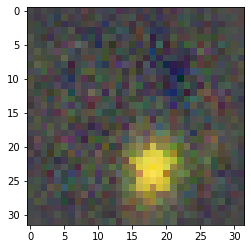

torch.Size([363, 363])


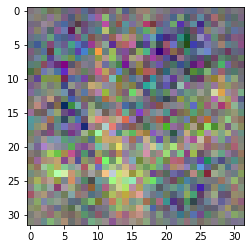

torch.Size([363, 363])


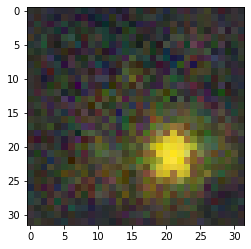

torch.Size([363, 363])


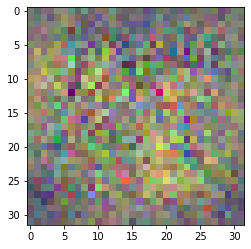

torch.Size([363, 363])


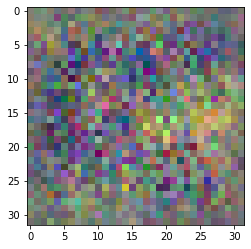

torch.Size([363, 363])


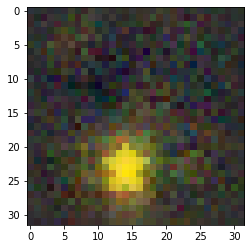

torch.Size([363, 363])


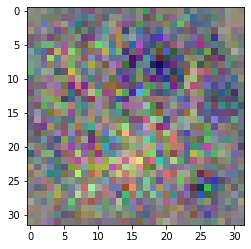

In [15]:
from torch.linalg import svd
from torch.nn.functional import fold

def expand_image(X, ps=3):
    """
    X : (n, c, p, q)
    out : (n, c, p*ps, q*ps)
    """

    n, c, p, q = X.shape

    pad_sz = ps//2
    X_patched = torch.from_numpy(np.pad(X, ((0,0),(0,0),(pad_sz,pad_sz),(pad_sz,pad_sz)), mode='wrap'))

    X_patched = X_patched.unfold(2,ps,1).unfold(3,ps,1) # (n, c, p, q, ps, ps)
    X_patched = rearrange(X_patched, 'n c p q ps qs -> n p q (c ps qs)', n=n, c=c, p=p, q=q, ps=ps, qs=ps)
    return X_patched

def multiply_patch(X_expanded, M):
    U, s, Vt = svd(M)
    s = torch.sqrt(torch.abs(s))
    M_sqrt = U @ torch.diag(s) @ Vt
    print(M_sqrt.shape)
    X_t = torch.einsum('n p q c, c C -> n p q C', X_expanded, M)
    return X_t


def fold_transformed(X, c=3, ps=3):
    n, p, q, d = X.shape
    X = X.reshape(n, p, q, c, ps, ps)
    X = rearrange(X, 'n p q c ps qs -> n (c ps qs) (p q)', n=n, p=p, q=q, c=c, ps=ps, qs=ps)
    pad = int((ps - 1) / 2)
    P = fold(X, output_size=(p, q), kernel_size=(ps, ps), padding=(pad, pad))
    return img_for_viewing(P)

# Here is how it looks after transforming with M
for i in range(10):
    sample_X = train_X[i].unsqueeze(0)
    X_expanded = expand_image(sample_X, ps=11)
    X_t = multiply_patch(X_expanded, torch.from_numpy(np.array(M)))
    P = fold_transformed(X_t, ps=11)
    plt.imshow(P)
    plt.show()